# Homework 7: Southern Ocean Reentrant Channel

#### Objective:
In this homework, we will investigate the effect of resolution on transient features and transport quantities using the Southern Ocean Reentrant Channel model.

#### Import Modules:
Begin by importing the modules to read in data, conduct calculations, and make plots.

In [1]:
# import the modules you need here - you may need to add as you go
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm

# this module will help organize your subplots
from matplotlib.gridspec import GridSpec

# this module will be used to mask out bathymetry features
from matplotlib.patches import Polygon

## Part 1: Modify, Compile and Run the Model

In this assignment, we are going to run the same model we ran in class - but this time, we will run at a resolution which is 10x higher than before. Follow the steps below to get the high resolution model set up.

#### Step 1: Clean Build and Run directories
For this model, we're going to need some clean build and run directories. If you already downloaded everything from the low resolution models in class, you can just remove all of the existing files in your run and bulid directories. Alternatively, you can make new versions e.g.

```
MITgcm/verification/tutorial_reentrant_channel
mkdir build_hires
mkdir run_hires
```

If you choose this option, be sure to replace "build" and "run" in the lines below with these new directories.

#### Step 2: Recompile the model

To compile the model for higher resolution, we're going to need to resize our domain. The new domain size is stored in the `SIZE.h_eddy` file in the code directory. To make this change, move to your code directory and then rename the SIZE.h_eddy file to SIZE.h. Then, in your build directory, compile with MPI.

#### Step 3: Prepare your run directory
To start, per the usual set up, copy everything from input to your run directory and link the `mitgcmuv` from build to run.

Then, on your local machine, run the `gendata.5km.py` script provided with the model input files. This should create the following files:
- SST_relax.5km.bin
- T_relax_mask.5km.bin
- bathy.5km.bin
- temperature.5km.bin
- zonal_wind.5km.bin

In addition, grab the pickup files from Canvas provided with this notebook and upload them to Spartan in your run directory.
  
Make a copy of these files in your run directory on Spartan.

Next, modify the following data* files:

1. Modify the data.pkg file to uncomment the line useGMRedi=.FALSE.,

2. Modify the data file to un/comment the lines for "eddy-permitting run":
- 4 lines in PARM01 
- comment out line for viscAh=2000 in parm01
- deltaT, nTimesteps, monitorFreq in PARM03
- delX and delY in PARM04
- 4x files in PARM05
  
3. Modify the data file to start at iteration 3483648 and run for two years (1 year = 360 days).

4. Modify the data.rbcs file to use the new lines

5. Modify the data.diagnostics file to be the same as that shown in class

#### Run the model
To run the model, you'll need to make a new job script. Consider the following questions:
- How many CPUs (tasks) will you need?
- Each node is 28 CPUs. How many nodes will you need? 

If you are in doubt, send Mike an email.

Note: this model run will take a couple hours!

## Part 2: Surface Conditions
Using your output from the high-resolution model produced by your new model run, make a movie comparing the low resolution model output to the high resolution output. The top row should show the low resolution output, as shown in the movie made in class, and the bottom row should show the fields at an identical timestep from the high resolution model. Be sure to resize and reorganize your plotting code from class to make a well-formatted movie.

In [2]:
# Edit the coding cells here to make your movie


## Part 3: Mean Hydrography
Again using your output from the high-resolution model, create a plot that shows mean properties along the channel ridge. You plot should have 8 panels - the 4 from class in one row, and the 4 from the new model in the bottom row.

In [3]:
# Edit the coding cells here to make your plot
model_folder = '/Users/cool/Workspace/MLML/ms274_fall2025/Homework/HW_7/run'
# model dimensions
n_rows = 400
n_cols = 200
Nr = 49

# create arrays for x, y, and z
dx = 5e3
dy = 5e3
x = np.arange(n_cols) * dx
y = np.arange(n_rows) * dy
r =  [5.48716549,   6.19462098,   6.99291201,   7.89353689,
         8.90937723,  10.05483267,  11.34595414,  12.80056778,
        14.43837763,  16.28102917,  18.35210877,  20.67704362,
        23.28285446,  26.1976981 ,  29.45012046,  33.06792588,
        37.07656002,  41.496912  ,  46.34247864,  51.61592052,
        57.30518684,  63.37960847,  69.78661289,  76.44996107,
        83.27047568,  90.13003112,  96.89898027, 103.44631852,
       109.65099217, 115.4122275 , 120.65692923, 125.34295968,
       129.45821977, 133.01641219, 136.05088105, 138.60793752,
       140.74074276, 142.50436556, 143.95220912, 145.133724  ,
       146.09317287, 146.86917206, 147.49475454, 147.99774783,
       148.40131516, 148.72455653, 148.98310489, 149.18968055,
       149.35458582]
Z = np.cumsum(r)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(model_folder, 'bathy.5km.bin'),
                    dtype='>f4').reshape(n_rows, n_cols)

grid = np.fromfile(os.path.join(model_folder, 'Diags', 'state_monthly.0002985984.data'), '>f4').reshape((4, Nr, n_cols, n_rows))

In [4]:
# make a function to output the following 3D grids:
# Theta, Uvel, Wvel

def read_3D_conditions_from_file(file_path):
    grid = np.fromfile(file_path, '>f4').reshape((4, Nr, n_cols, n_rows))
     # fields(1:4,2) =   'THETA   ', 'VVEL    ', 'UVEL    ',
     #               'WVEL    ',
    theta = grid[0]
    vvel = grid[1]
    uvel = grid[2]
    wvel = grid[3]
    return theta, vvel, uvel, wvel 

path = os.path.join(model_folder, 'Diags', 'state_monthly.0002985984.data')
theta, vvel, uvel, wvel  = read_3D_conditions_from_file(path)
np.size(theta)
np.shape(theta)
shaper = theta

In [5]:
print(2985984 - 2747520)
initial_i = 2747520
step_size = 238464
end_i = 2985984
iteration_numbers = np.arange(initial_i, end_i+1, step_size)


def average_3D_files(iteration_numbers):
    avg_theta = np.zeros_like(shaper)
    avg_vvel = np.zeros_like(shaper)
    avg_uvel = np.zeros_like(shaper)
    avg_wvel = np.zeros_like(shaper)
    n = len(iteration_numbers)
    for i in iteration_numbers:
        path = os.path.join(model_folder, 'Diags', 'state_monthly.000' + str(i) + '.data')
        theta, vvel, uvel, wvel  = read_3D_conditions_from_file(path)
        avg_theta += theta 
        avg_vvel += vvel
        avg_uvel += uvel 
        avg_wvel += wvel
    return avg_theta/n, avg_vvel/n, avg_uvel/n, avg_wvel/n

238464


In [6]:
# compute the average 3D field of the above files
Theta, Vvel, Uvel, Wvel = average_3D_files(iteration_numbers)

H = 4000.0   # total depth (m)
dz = H / Nr

# RC = cell center depths (negative values)
RC = - (np.arange(Nr) + 0.5) * dz
np.shape(Theta)
# np.shape(Theta[:,:, 20])

(49, 200, 400)

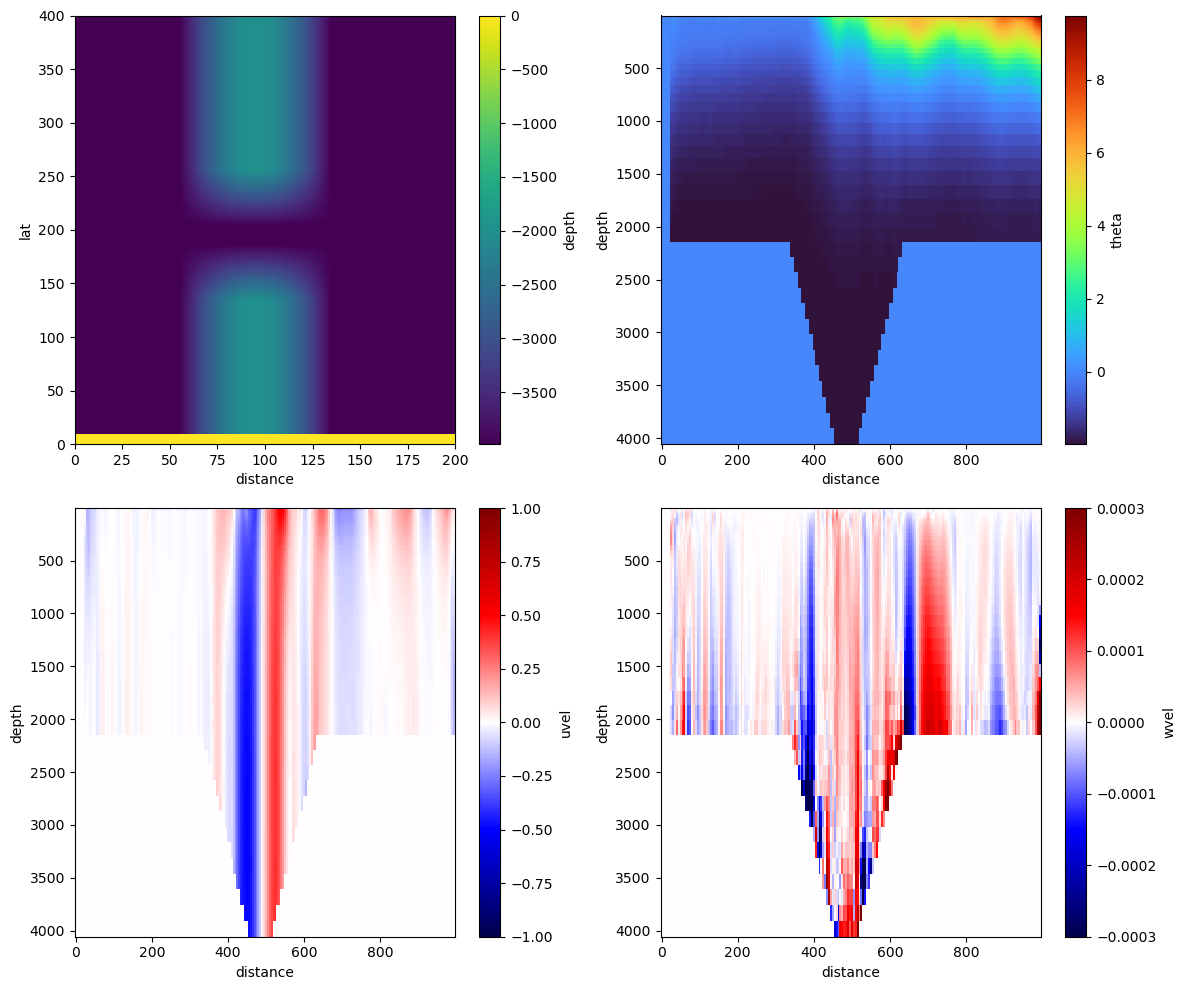

In [7]:
# make your figure here
fig = plt.figure(figsize = (12,10))

plt.subplot(2,2,1)
plt.pcolormesh(bathy)
plt.colorbar(label='depth')
plt.xlabel('distance')
plt.ylabel('lat')


plt.subplot(2,2,2)
plt.pcolormesh(x/1000, Z, Theta[:,:, 100], cmap='turbo')
plt.colorbar(label='theta')
plt.ylabel('depth')
plt.xlabel('distance')
plt.gca().invert_yaxis()


plt.subplot(2,2,3)
plt.pcolormesh(x/1000, Z, Uvel[:,:, 100], cmap='seismic', vmin=-1, vmax=1)
plt.colorbar(label='uvel')
plt.ylabel('depth')
plt.xlabel('distance')
plt.gca().invert_yaxis()

plt.subplot(2,2,4)
plt.pcolormesh(x/1000, Z, Wvel[:,:, 100], cmap='seismic', vmin=-0.0003, vmax=0.0003)
plt.colorbar(label='wvel')
plt.ylabel('depth')
plt.xlabel('distance')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


## Part 4: Heat Flux Timeseries
You probably see where this one is going - in this section, re-create your timeseries plot from class for mean temperature and zonal velocity, and total heat flux on a transect across the ridge. Each of the three panels should now have 2 lines - one for the coarse resolution model and one for the high resolution model.

In [8]:
# Edit the coding cells here to make your plot

## Part 5: Model Differences
In the markdown cell below, write a paragraph describing the differences in the model runs that resulted from changing the resolution. Some key questions to consider:
- What are the key changes to the model output?
- What causes the variabiliy in the higher resolution model that was not present in the lower resolution model? Note here that the external forcing conditions are identical!
- What is consistent between the model runs?
- How well do you think the low resolution model captures the features of the higher resolution model?
- What generalizations can we make about coarse resolution global ocean models based on this comparison?

- the key change is the resolution has been changed from 50km x,y to 5km x,y resolution, which is a big shift in magnitude
- a lot of the variability missing from the higher res model is from the lower resolution not being able to capture smaller eddies, which cause a lot more variability at a lower scale particularly for  velocity. Though it is also seen in temperature, where in higher resolution there is much more vertical mixing impacting the thermocline, with a much less clear, and less shallow boundary.
- overall stratification of the warmer layer against the cooler layer is still well represented between models.
- temperature is still fairly well captured in the low res model, and you get a view of the major ocean current. however a lot of mixing and turbulence missing from all the eddies in the region lead to a lot of velocity variability to be missing in the lower res model. this also makes the startification to be more artificially set with clearer boundaries than it really is. 
- high level features such as major currents and the overall thermocline can be captured, but a lot of smaller scale variations from eddies and its associated mixing and the impacts it has on velocity and temperature mixing is missed.